#### Importing libraries

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import numpy as np
import matplotlib
import statsmodels.api as sm


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [78]:
df = pd.read_csv("/Users/ana/ironhack_coding/projects/final_project/final-project/datasets/instagram_topics.csv",
                       parse_dates = ["Date"])

# only relevant columns and data
data = df.groupby(["Date", "Dominant_Topic"]).size().reset_index()

#tweaking new dataframe
data['Date'] = [d.date() for d in data['Date']]
data.rename(columns = {0:"no_posts"}, inplace= True)
data = data.sort_values(by="Date", ascending = False)

In [79]:
data.head()

,Date,Dominant_Topic,no_posts
11660,2020-03-12,9.0,1
10990,2020-03-12,5.0,1
11003,2020-03-12,11.0,1
11002,2020-03-12,10.0,1
11001,2020-03-12,5.0,1


In [4]:
data.dtypes # it should be dastetime ?

Date               object
Dominant_Topic    float64
no_posts            int64
dtype: object

##### What is Arima?
ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

In [81]:
test = data[data.Dominant_Topic == 0.0]
test.index = test["Date"] # index to date for time series analysis
test = test.groupby(test.index).agg({"no_posts":sum})

test.head()



,no_posts
Date,
2016-07-24,2
2017-02-02,1
2017-02-04,1
2017-08-07,1
2018-06-03,1


In [82]:
test.tail()



,no_posts
Date,
2020-03-08,48
2020-03-09,76
2020-03-10,103
2020-03-11,176
2020-03-12,217


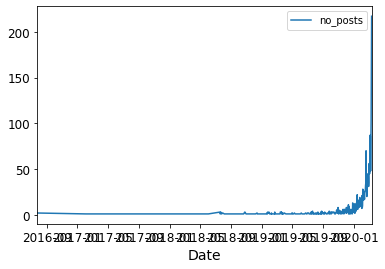

In [83]:
test.plot()



In [33]:
# dealing with NAN - > maybe 0 values
test.isna().sum()

no_posts    0
dtype: int64

In [38]:
test.isnull().sum()

no_posts    0
dtype: int64

In [37]:
# no zero values
test[test.no_posts == 0]

,no_posts
Date,


In [84]:
test.index = pd.to_datetime(test.index)
test.index




DatetimeIndex(['2016-07-24', '2017-02-02', '2017-02-04', '2017-08-07',
               '2018-06-03', '2018-06-04', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22',
               ...
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12'],
              dtype='datetime64[ns]', name='Date', length=343, freq=None)

In [85]:
# there are missing dates, dealing with it:
idx = pd.date_range('2016-07-24', '2020-03-12')

test = test.reindex(idx, fill_value=0)



In [55]:
test.shape


(1328, 1)

In [87]:
# only last three months


test = test.loc["2019-12-1" : "2020-3-12"]
test.head()


,no_posts
2019-12-01,2
2019-12-02,2
2019-12-03,8
2019-12-04,2
2019-12-05,4


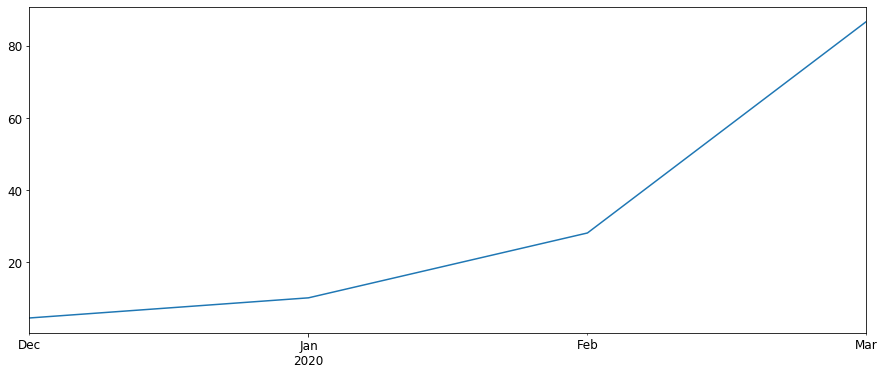

In [89]:
test['no_posts'].resample('MS').mean().plot(figsize=(15, 6))

y = test['no_posts'].resample('MS').mean()



### ARIMA Model




In [91]:
from statsmodels.tsa.stattools import adfuller

adfuller(y, autolag = "AIC")


(300.73551992428304,
 1.0,
 0,
 3,
 {'1%': -10.41719074074074,
  '5%': -5.77838074074074,
  '10%': -3.391681111111111},
 -3.0028118148780294)

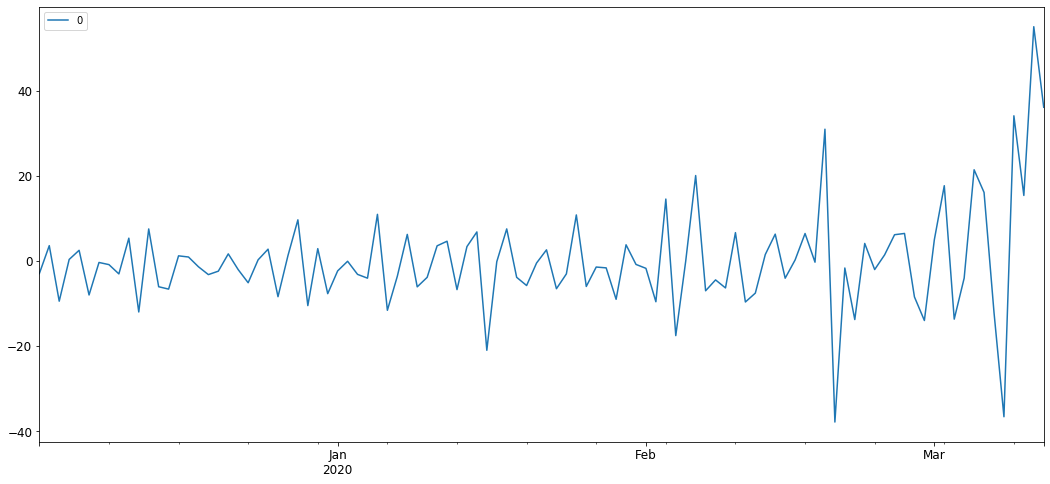

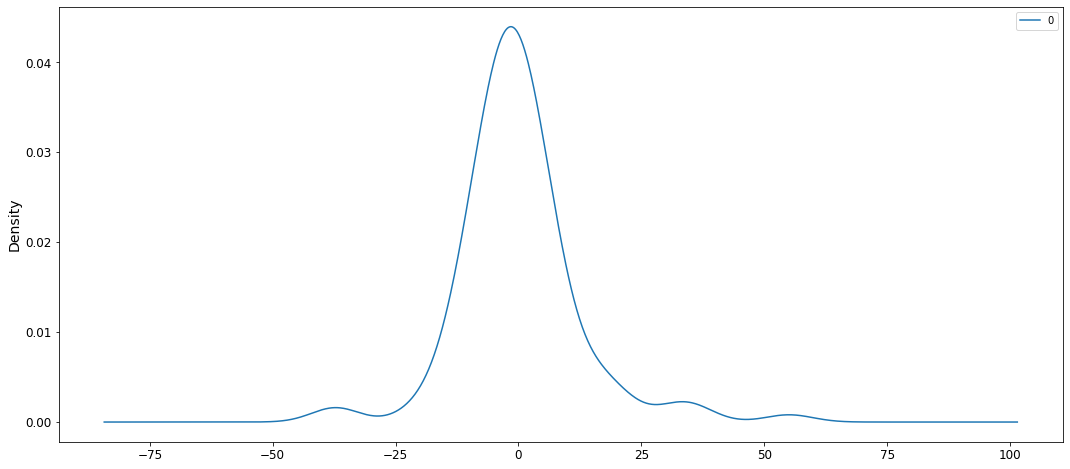

                0
count  102.000000
mean     0.032053
std     12.244146
min    -37.838233
25%     -6.070494
50%     -1.103185
75%      4.043942
max     55.051397


In [93]:
from statsmodels.tsa.arima_model import ARIMA
 
model = ARIMA(test, order=(5,1,0))
model_fit = model.fit(disp=0)

# print(model_fit.summary())

# plot residual errors: residual of an observed value is 
# the difference between the observed value and the estimated value of the quantity of interest 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Forecasting

Test MSE: 791.279


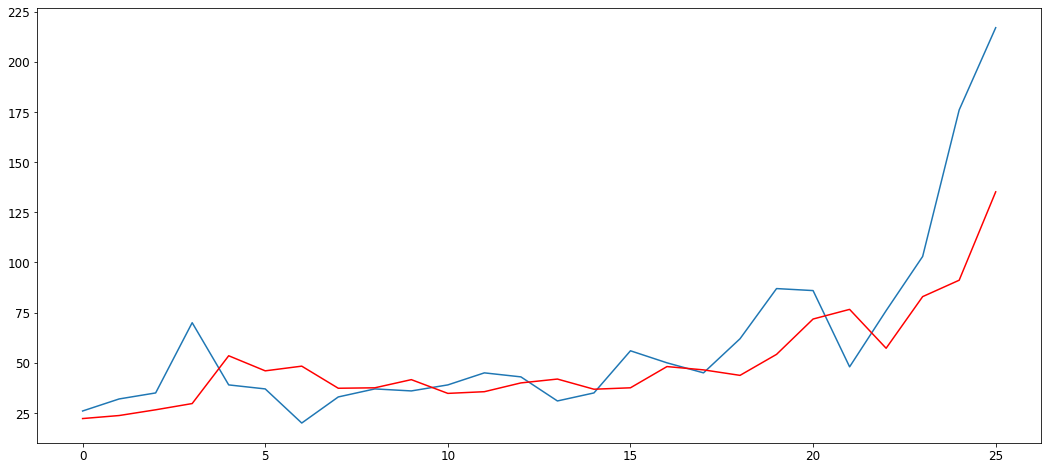

In [95]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
X = test.values
size = int(len(X) * 0.75)   # Split percentage

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t] # you forecast the next "point" continuosly
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# this is just the test, the train preceeds it